This is the first of a series of posts discussing a side project I'm working on. Long term, I'm interested in solving the PDEs I'm studying in my research using deep neural networks. This is a natural approach, but having not implemented such a program before, I'm starting with some easier problems to get myself familiar with the implementation of such a solver using Pytorch. Most of my experience up until recently has been with Tensorflow (I have a Tensorflow Developer certification from Coursera). So far, I've enjoyed Pytorch and I've found it much more intuitive than Tensorflow. 

## Poisson Equation
The first toy problem I present here is the Poisson Equation with Dirichlet boundary condition on the unit disk. I've chosen a very simple relationship for $\Delta u$ and the boundary condition to quickly show that the neural network I train differs only slightly from the analytical solution.

The problem I solve is this,

$$\Delta u(x,y)=1\quad (x,y)\in B_1(0)$$
$$u(x,y)=0\quad (x,y)\in\partial B_1(0)$$

in $\mathbb{R}^2$. The analytical solution to this problem is easily seen to be $u(x,y)=\frac{1}{4}(x^2+y^2-1)$. 

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.animation as animation

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will use a very simple neural network.

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(2, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.sequential_model(x)

Here, we define a function which samples the necessary data to train the network (and test the network later).

In [67]:
def SampleFromUnitDisk(points):
    d = torch.distributions.Uniform(-5,5)
    d_t = torch.distributions.Uniform(0,5)

    x = torch.Tensor(points,1)
    t = torch.Tensor(points,1)
    j=0

    while j<points:
        x[j,0] = d.sample()
        t[j,0] = d_t.sample()
        j+=1

    return x, t

In [83]:
x, t = SampleFromUnitDisk(10000)

Now, we generate the training data.

Let's discuss the loss function. Since we've descritized the domain, we are going to use a discrete mean-squared error function to compute the loss. In our case, we want to minimize the following,

$$L(x_{\text{int}},y_\text{int}, x_{\text{bdry}},y_{\text{bdry}}):=\frac{1}{N_{\text{int}}}\sum_{j=1}^{N_{\text{int}}}|\Delta u(x^{(j)}_{\text{int}},y^{(j)}_{\text{int}})-1|^2+\frac{1}{N_{\text{bdry}}}\sum_{j=1}^{N_{\text{bdry}}}|u(x^{(j)}_{\text{bdry}},y^{(j)}_{\text{bdry}})|^2$$

The first term comes from the fact that $\Delta u(x,y)=1$ on the interior, while $u=0$ identically on the boundary. To implement this, we define the following.

In [84]:
def g(x):
    if x<0:
        return 1
    elif x>0 and x<1:
        return 1-x
    else:
        return 0

In [85]:
def loss(x, t, network):
    x.requires_grad = True
    t.requires_grad = True
    k = x
    t_0=torch.zeros(10000).unsqueeze(1)
    temp_input = torch.cat((x,t),1)
    z=network(temp_input)
    zinit = network(torch.cat((x, t_0),1))

    dz_dx = torch.autograd.grad(z.sum(), x, create_graph = True)[0]
    dz_dt = torch.autograd.grad(z.sum(), t, create_graph = True)[0] 

    return torch.mean((dz_dx*z+dz_dt)**2)+torch.mean((zinit-k.detach().apply_(g))**2)

Okay now let's create our network and train it! We'll use 2000 epochs.

In [86]:
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)

epochs = 50000
loss_values = np.zeros(50000)
for i in range(epochs):
    l = loss(x, t, model)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_values[i]=l
    if i%1000==0:
        print("Loss at epoch {}: {}".format(i, l.item()))

Loss at epoch 0: 1.511480450630188
Loss at epoch 1000: 0.02721107006072998
Loss at epoch 2000: 0.026105497032403946
Loss at epoch 3000: 0.02599753625690937
Loss at epoch 4000: 0.02595333196222782
Loss at epoch 5000: 0.025913238525390625
Loss at epoch 6000: 0.025874311104416847
Loss at epoch 7000: 0.025836490094661713
Loss at epoch 8000: 0.02579987607896328
Loss at epoch 9000: 0.025764452293515205
Loss at epoch 10000: 0.025730101391673088
Loss at epoch 11000: 0.0256966520100832
Loss at epoch 12000: 0.025663886219263077
Loss at epoch 13000: 0.025631550699472427
Loss at epoch 14000: 0.025599384680390358
Loss at epoch 15000: 0.025567123666405678
Loss at epoch 16000: 0.025534508749842644
Loss at epoch 17000: 0.025501295924186707
Loss at epoch 18000: 0.025467244908213615
Loss at epoch 19000: 0.025432126596570015
Loss at epoch 20000: 0.0253957137465477
Loss at epoch 21000: 0.025357801467180252
Loss at epoch 22000: 0.02531818486750126
Loss at epoch 23000: 0.02527666836977005
Loss at epoch 2400

Cool, so it seems like we've decreased the loss significantly. This is enough for our toy example. Here's the loss decrease over the course of training:

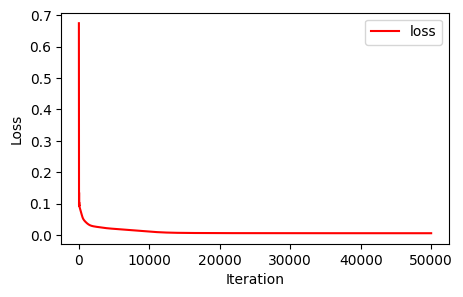

In [8]:
x_axis = np.linspace(0,50000,50000)[:,None]
plt.figure(figsize=(5,3))
plt.plot(x_axis,loss_values,'red', label='loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

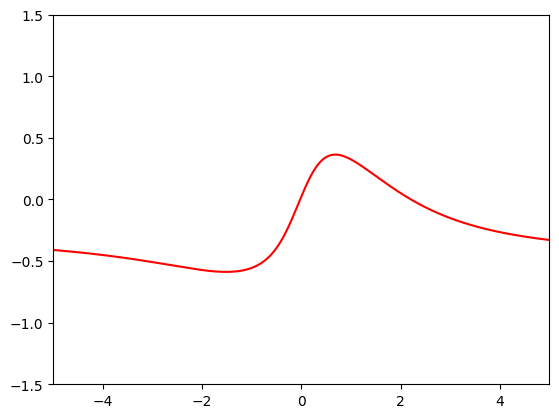

In [88]:
x_axis = torch.linspace(-5,5,10000).unsqueeze(1)
t=0

t_val = torch.ones(10000).unsqueeze(1)*t
values = model(torch.cat((x_axis,t_val),1))

def update_plot(t):
    t_val = torch.ones(10000).unsqueeze(1)*t/20
    values = model(torch.cat((x_axis,t_val),1))
    points.set_data(x_axis.detach(),values.detach())
    return points

fig = plt.figure()
ax = plt.axes(xlim=(-5,5),ylim=(-1.5, 1.5))
points, =ax.plot(x_axis.detach(),values.detach(),'red', label='u(x,t)')
ani = animation.FuncAnimation(fig,update_plot,frames=100,repeat=False)
plt.show()
ani.save('test.gif', writer='pillow')
#while t<=5:
#    if t==0:
#        points, =ax.plot(x_axis.detach(),values.detach(),'red', label='u(x,t)')
#        ax.set_xlim(-5,5)
#        ax.set_ylim(0,2)
#    else:
#        points.set_data(x_axis.detach(),values.detach())
    
#    plt.pause(0.5)
#    t+=0.1

#plt.figure(figsize=(5,3))
#plt.plot(x_axis.detach(),values.detach(),'red', label='u(x,t)')
#plt.xlabel('x')
#plt.ylabel('u(x,t)')
#plt.legend()

In [91]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(2, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        return self.sequential_model(x)

In [90]:
x, t = SampleFromUnitDisk(10000)

In [95]:
def loss2(x, t, network):
    x.requires_grad = True
    t.requires_grad = True
    t_0=torch.zeros(10000).unsqueeze(1)
    temp_input = torch.cat((x,t),1)
    z=network(temp_input)
    zinit = network(torch.cat((x, t_0),1))

    k = x-z*t
    n = x

    return torch.mean((z-k.detach().apply_(g))**2)+torch.mean((zinit-n.detach().apply_(g))**2)

In [96]:
model2 = NeuralNetwork2()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=.9)

epochs = 50000
loss_values2 = np.zeros(50000)
for i in range(epochs):
    l = loss2(x, t, model2)
    l.backward()
    optimizer2.step()
    optimizer2.zero_grad()
    loss_values2[i]=l
    if i%1000==0:
        print("Loss at epoch {}: {}".format(i, l.item()))

Loss at epoch 0: 0.9301759600639343
Loss at epoch 1000: 0.06250112503767014
Loss at epoch 2000: 0.05261428654193878
Loss at epoch 3000: 0.04801388084888458
Loss at epoch 4000: 0.04525195062160492
Loss at epoch 5000: 0.043427735567092896
Loss at epoch 6000: 0.04209195449948311
Loss at epoch 7000: 0.04101116210222244
Loss at epoch 8000: 0.040071215480566025
Loss at epoch 9000: 0.0392165444791317
Loss at epoch 10000: 0.0384175069630146
Loss at epoch 11000: 0.037654101848602295
Loss at epoch 12000: 0.03690784052014351
Loss at epoch 13000: 0.03615432232618332
Loss at epoch 14000: 0.03536562621593475
Loss at epoch 15000: 0.03450819477438927
Loss at epoch 16000: 0.033549606800079346
Loss at epoch 17000: 0.03247258812189102
Loss at epoch 18000: 0.03126995638012886
Loss at epoch 19000: 0.02996484376490116
Loss at epoch 20000: 0.02859281189739704
Loss at epoch 21000: 0.02719927579164505
Loss at epoch 22000: 0.025833280757069588
Loss at epoch 23000: 0.02452877163887024
Loss at epoch 24000: 0.0233

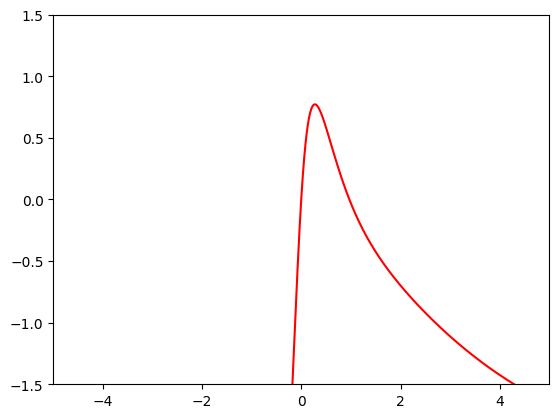

In [97]:
x_axis = torch.linspace(-5,5,10000).unsqueeze(1)
t=0

t_val = torch.ones(10000).unsqueeze(1)*t
values = model2(torch.cat((x_axis,t_val),1))

def update_plot(t):
    t_val = torch.ones(10000).unsqueeze(1)*t/20
    values = model2(torch.cat((x_axis,t_val),1))
    points.set_data(x_axis.detach(),values.detach())
    return points

fig = plt.figure()
ax = plt.axes(xlim=(-5,5),ylim=(-1.5,1.5))
points, =ax.plot(x_axis.detach(),values.detach(),'red', label='u(x,t)')
ani = animation.FuncAnimation(fig,update_plot,frames=100,repeat=False)
plt.show()
ani.save('test2.gif', writer='pillow')
#while t<=5:
#    if t==0:
#        points, =ax.plot(x_axis.detach(),values.detach(),'red', label='u(x,t)')
#        ax.set_xlim(-5,5)
#        ax.set_ylim(0,2)
#    else:
#        points.set_data(x_axis.detach(),values.detach())
    
#    plt.pause(0.5)
#    t+=0.1

#plt.figure(figsize=(5,3))
#plt.plot(x_axis.detach(),values.detach(),'red', label='u(x,t)')
#plt.xlabel('x')
#plt.ylabel('u(x,t)')
#plt.legend()

In [33]:
network_function(1,1).item()

0.6474412679672241

Now, let's simulate a sup-norm test agains the analytic solution, using a test set of data.

In [250]:
x_test, y_test, xbdry_test, ybdry_test = SampleFromUnitDisk(10000)

with torch.no_grad():
    z = model(torch.cat((x_test,y_test),1))-(1/4*(x_test**2+y_test**2-1))
    print("Interior sup-norm error: {}".format(torch.max(abs(z)).item()))

with torch.no_grad():
    z = model(torch.cat((xbdry_test,ybdry_test),1))-(1/4*(xbdry_test**2+ybdry_test**2-1))
    print("Boundary sup-norm error: {}".format(torch.max(abs(z)).item()))

Interior sup-norm error: 0.04881325364112854
Boundary sup-norm error: 0.04888451099395752


Of course, we want to do better, but this is pretty decent for this toy example.

Cool, so we have a baseline implementation for solving PDEs using neural networks. This was of course extremely simple. I started messing with more complicated PDEs (quasilinear, nonlinear) and ran into challenges in both implementation and validation. There are some theoretical questions on how to deal with non-uniqueness of solutions and how to give an "ansatz" when initializaing training. Some of this will probably be the subject of my next post. 